In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

2024-04-25 17:14:46.928470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 17:14:46.928573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 17:14:47.073577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [18]:
filelist_trainx = sorted(glob.glob('/kaggle/input/smalldataset/smallDataset/trainx/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/kaggle/input/smalldataset/smallDataset/trainy/*.png'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [19]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (5000, 224, 224, 3)
Y_train shape: (5000, 224, 224)


In [20]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

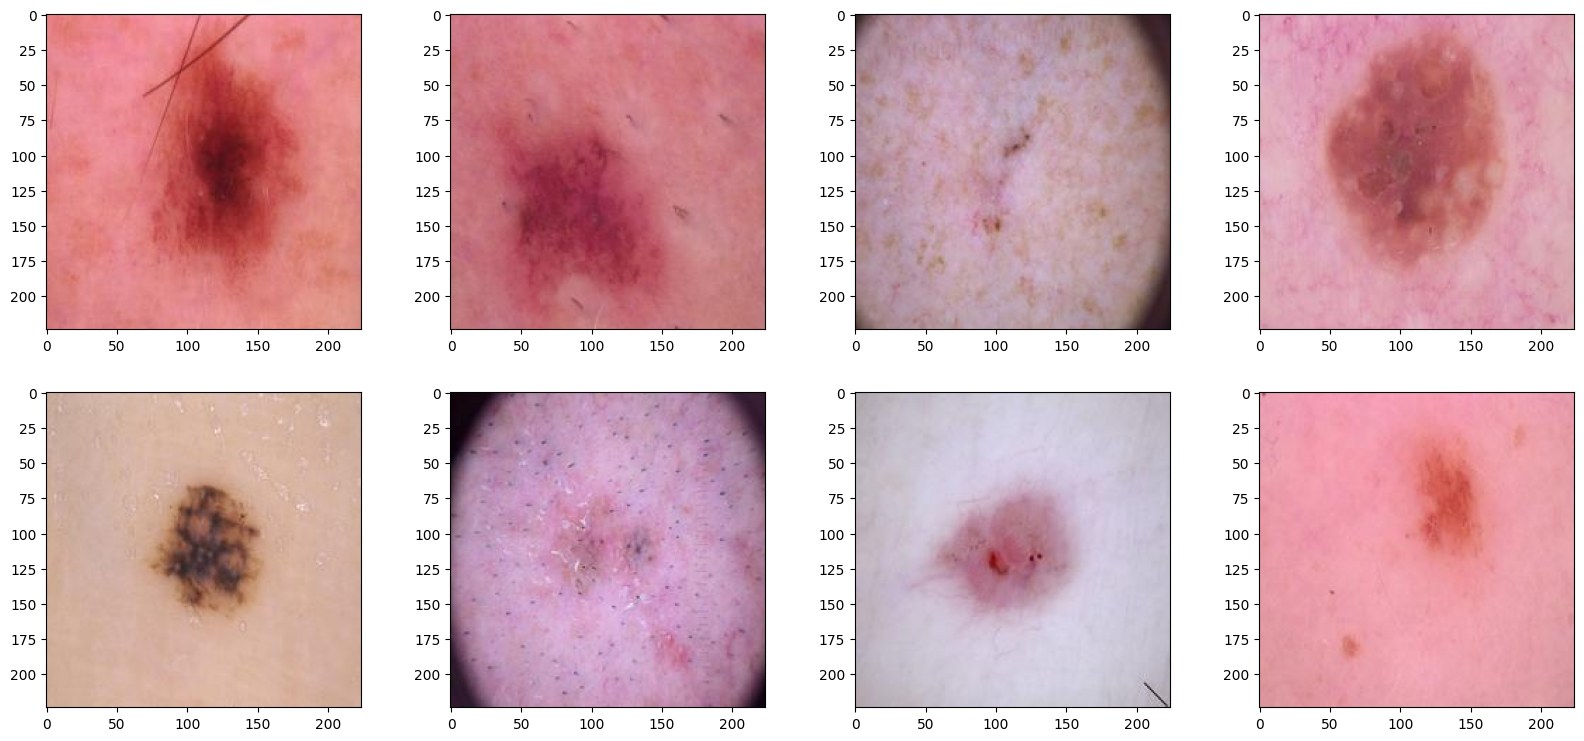

In [7]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

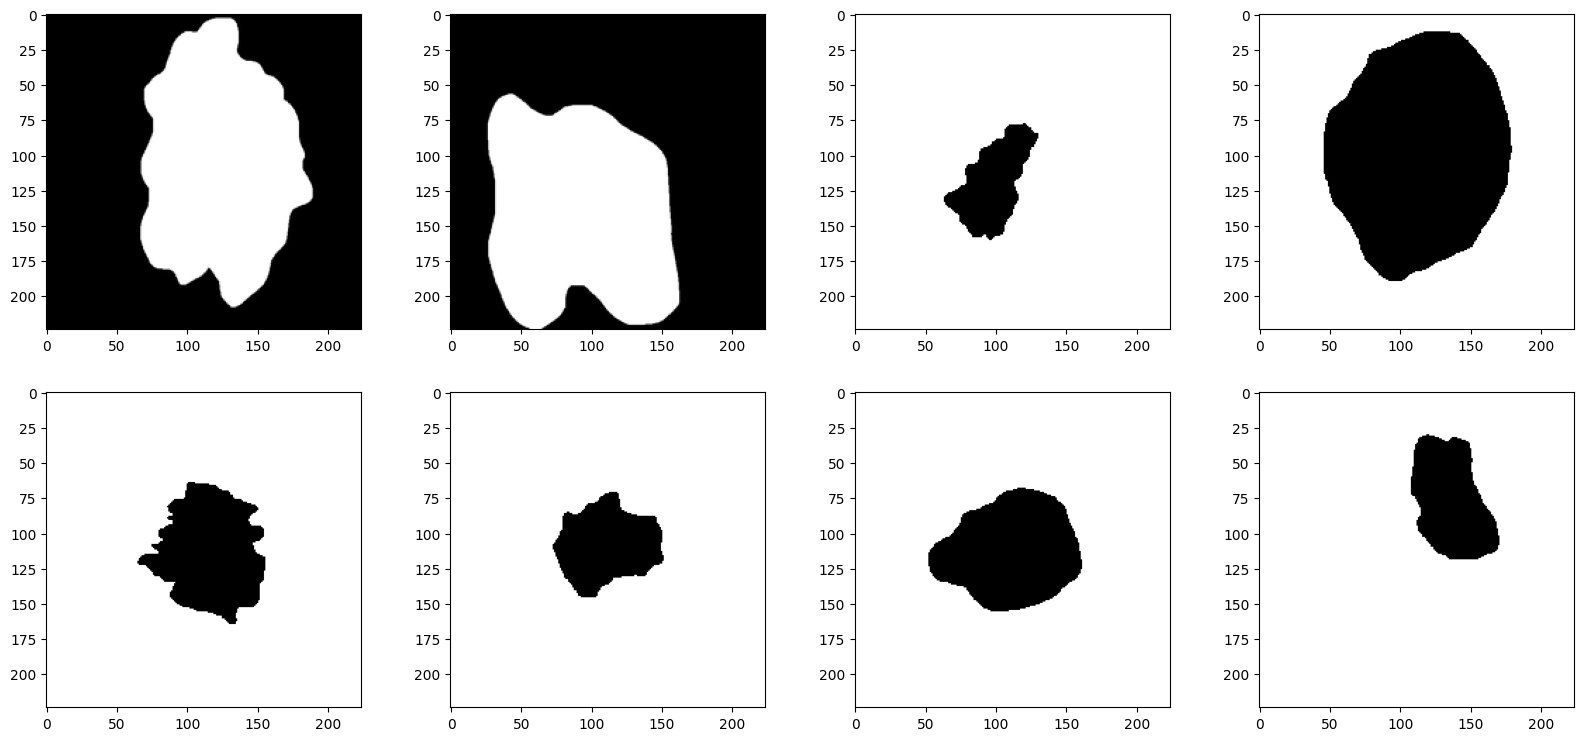

In [8]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

In [9]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [10]:
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [11]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [12]:

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [14]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [15]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [21]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 101)

In [22]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 4000
Length of the Test Set       : 1250
Length of the Validation Set : 1000


In [23]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [31]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import SpatialDropout2D

def load_pretrained_unet(weights_path):
    # Load the architecture of the pre-trained U-Net model (without weights)
    with open(weights_path + '.json', 'r') as json_file:
        json_config = json_file.read()
    pretrained_model = model_from_json(json_config)

    # Load the weights of the pre-trained U-Net model
    pretrained_model.load_weights(weights_path)

    # Iterate through the layers of the model
    for layer in pretrained_model.layers:
        # If the layer is a SpatialDropout2D layer, initialize a new layer with the same parameters
        if isinstance(layer, SpatialDropout2D):
            new_layer = SpatialDropout2D(rate=layer.rate)
            # Transfer weights from the pre-trained layer to the new layer
            new_layer.build(layer.input_shape)
            new_layer.set_weights(layer.get_weights())
            # Replace the pre-trained layer with the new layer
            pretrained_model.get_layer(name=layer.name).set_weights(new_layer.get_weights())

    return pretrained_model


In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.models import load_model




def fine_tune_unet(pretrained_model, epochs_num, savename):
    # Replace the input layer with new input shape
    inputs = Input((224, 224, INPUT_CHANNELS))
    
    # Freeze layers except the last convolutional layer and up-convolutional layers
    for layer in pretrained_model.layers[:-13]:
        layer.trainable = False
    
    # Replace the output layer with a new one
    up_conv_224 = pretrained_model.layers[-4].output
    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224, 224))(conv_final)

    # Create a new model
    fine_tuned_model = Model(inputs, pred, name="Fine_Tuned_UNET")
    
    # Compile the model
    
    fine_tuned_model.compile(optimizer=Adam(learning_rate=0.003),
                             loss=[jaccard_distance],
                             metrics=[iou, dice_coe, Precision(), Recall(), accuracy])
    
    fine_tuned_model.summary()

    # Fine-tune the model
    hist = fine_tuned_model.fit(x_train, y_train, epochs=epochs_num, batch_size=18,
                                validation_data=(x_val, y_val), verbose=1)
    
    # Save the fine-tuned model
    fine_tuned_model.save('/kaggle/working/'+savename)
    
    return fine_tuned_model, hist




In [42]:
weights_path = '/kaggle/input/unet/tensorflow2/unet_100_pretrained/1/unet_100_epoch (1).h5'  # Path to the pre-trained weights
epochs_num = 1  # Number of epochs for fine-tuning
savename = 'retrain_unet_1_ep.keras'  # Path to save the trained model

# Call the function
model, history = unet_transfer_learning(weights_path, epochs_num, savename)

Model: "UNET_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 224, 224,  │          0 │ activation_1[0][… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 112, 112,  │          0 │ activation_3[0][… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ spatial_dropout2

 Total params: 31,466,753 (120.04 MB)

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

2024-04-25 17:33:02.015852: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 4.85241, expected 3.99591
2024-04-25 17:33:02.015923: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 7.11791, expected 6.26141
2024-04-25 17:33:02.015938: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 7.22171, expected 6.36521
2024-04-25 17:33:02.015953: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.92082, expected 6.06432
2024-04-25 17:33:02.015967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 6.65139, expected 5.7949
2024-04-25 17:33:02.015980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 6.62069, expected 5.7642
2024-04-25 17:33:02.015990: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 6.58323, expected 5.72673
2024-04-25 17:33:02.01

222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6748 - dice_coe: 0.7702 - iou: 0.3486 - loss: 0.6514 - precision: 0.9000 - recall: 0.3519

2024-04-25 17:34:34.874267: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.27163, expected 3.68847
2024-04-25 17:34:34.874331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.66001, expected 4.07686
2024-04-25 17:34:34.874341: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.99414, expected 3.41098
2024-04-25 17:34:34.874349: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.62205, expected 4.03889
2024-04-25 17:34:34.874357: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.06311, expected 3.47995
2024-04-25 17:34:34.874366: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.7913, expected 4.20815
2024-04-25 17:34:34.874374: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 4.23189, expected 3.64874
2024-04-25 17:34:34.874382: E external/local_xla/x

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6748 - dice_coe: 0.7698 - iou: 0.3486 - loss: 0.6514 - precision: 0.9000 - recall: 0.3517

2024-04-25 17:35:07.426785: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.44023, expected 3.56217
2024-04-25 17:35:07.426863: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.72784, expected 5.84979
2024-04-25 17:35:07.426874: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.1489, expected 6.27084
2024-04-25 17:35:07.426882: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.06006, expected 6.182
2024-04-25 17:35:07.426890: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.53803, expected 5.65998
2024-04-25 17:35:07.426899: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.15196, expected 6.27391
2024-04-25 17:35:07.426907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.05401, expected 5.17595
2024-04-25 17:35:07.426917: E external/local_xla/xla/servi


Epoch 1: val_loss improved from inf to 0.67542, saving model to retrain_unet_1_ep.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 161s 412ms/step - accuracy: 0.6748 - dice_coe: 0.7693 - iou: 0.3485 - loss: 0.6515 - precision: 0.9001 - recall: 0.3515 - val_accuracy: 0.6436 - val_dice_coe: 1.1081 - val_iou: 0.3246 - val_loss: 0.6754 - val_precision: 0.8447 - val_recall: 0.5299


In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy

def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

def unet_transfer_learning(weights_path, epochs_num, savename):

    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)

    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")

    # Load pre-trained weights
    model.load_weights(weights_path)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.003),
                  loss=[jaccard_distance],
                  metrics=[iou, dice_coe,Precision(), Recall(), accuracy])
    

    model.summary()

    # Define checkpoint to save the best model
    checkpoint = ModelCheckpoint(savename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    # Train the model
    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=18, 
                     validation_data=(x_val, y_val), verbose=1,
                     callbacks=callbacks_list)

    # Save the trained model
    model.save('/kaggle/working/'+savename)

    return model, hist


In [43]:
weights_path = '/kaggle/input/unet/tensorflow2/unet_100_pretrained/1/unet_100_epoch (1).h5'  # Path to the pre-trained weights
epochs_num = 100  # Number of epochs for fine-tuning
savename = 'retrain_unet_100_ep.keras'  # Path to save the trained model

# Call the function
model, history = unet_transfer_learning(weights_path, epochs_num, savename)

Model: "UNET_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_23[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 224, 224,  │          0 │ activation_24[0]… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 112, 112,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_25[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 112, 112,  │          0 │ activation_26[0]… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 56, 56,    │          0 │ spatial_dropout2

 Total params: 31,466,753 (120.04 MB)

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6668 - dice_coe: 0.7641 - iou: 0.3365 - loss: 0.6635 - precision_1: 0.8931 - recall_1: 0.3509
Epoch 1: val_loss improved from inf to 0.67312, saving model to retrain_unet_100_ep.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 120s 339ms/step - accuracy: 0.6668 - dice_coe: 0.7636 - iou: 0.3366 - loss: 0.6634 - precision_1: 0.8932 - recall_1: 0.3506 - val_accuracy: 0.6552 - val_dice_coe: 0.9049 - val_iou: 0.3269 - val_loss: 0.6731 - val_precision_1: 0.8734 - val_recall_1: 0.4244
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6679 - dice_coe: 0.6696 - iou: 0.3346 - loss: 0.6654 - precision_1: 0.9182 - recall_1: 0.2993
Epoch 2: val_loss did not improve from 0.67312
223/223 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.6680 - dice_coe: 0.6694 - iou: 0.3346 - loss: 0.6654 - precision_1: 0.9182 - recall_1: 0.2992 - val_accuracy: 0.6470 - val_dice_coe: 1.0251 - val_iou: 0.3265 - val_loss: 0.6735 - val_precision_1

In [32]:
# Load the pre-trained U-Net model
pretrained_model = load_pretrained_unet('/kaggle/input/unet/tensorflow2/unet_100_pretrained/1/unet_100_epoch (1).h5')

# Fine-tune the pre-trained model


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/unet/tensorflow2/unet_100_pretrained/1/unet_100_epoch (1).h5.json'

In [ ]:
model, hist = fine_tune_unet(pretrained_model, epochs_num, 'fine_tuned_unet.keras', x_train, y_train, x_val, y_val)

In [ ]:

def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save('/kaggle/working/' + savename)
    return model, hist

In [ ]:
model, hist = UNET_224(1, 'unet_1_epoch.h5')

In [ ]:
model, hist = UNET_224(epochs_num= 100, savename= 'unet_100_epoch.h5')

In [44]:
dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)


In [50]:
model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer=Adam(learning_rate=0.003),
                  loss=[jaccard_distance],
                  metrics=[iou, dice_coe,Precision(), Recall(), accuracy])

In [46]:
model_1.load_weights('/kaggle/working/retrain_unet_100_ep.keras')

In [51]:

print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.5153 - dice_coe: 1.3862 - iou: 0.3378 - loss: 0.6622 - precision_4: 0.5753 - recall_4: 0.6801
________________________
IOU:       |   34.15  |
Dice Coef: |   140.20  |
Precision: |   57.80  |
Recall:    |   68.59  |
Accuracy:  |   51.87  |
Loss:      |   65.85  |
________________________

-------------On Test  Set--------------------------

69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4980 - dice_coe: 1.3223 - iou: 0.3202 - loss: 0.6798 - precision_4: 0.5632 - recall_4: 0.6436

2024-04-25 18:54:43.136120: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.75204, expected 2.80617
2024-04-25 18:54:43.136198: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.5929, expected 3.64702
2024-04-25 18:54:43.136208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.49398, expected 4.54811
2024-04-25 18:54:43.136244: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.96573, expected 4.01986
2024-04-25 18:54:43.136253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.20058, expected 3.25471
2024-04-25 18:54:43.136262: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.83434, expected 4.88847
2024-04-25 18:54:43.136270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.77851, expected 3.83264
2024-04-25 18:54:43.136279: E external/local_xla/xla/ser

70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.4984 - dice_coe: 1.3237 - iou: 0.3205 - loss: 0.6795 - precision_4: 0.5633 - recall_4: 0.6443
________________________
IOU:       |   33.01  |
Dice Coef: |   137.29  |
Precision: |   56.64  |
Recall:    |   67.04  |
Accuracy:  |   51.02  |
Loss:      |   66.99  |
________________________

-------------On validation Set---------------------

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4955 - dice_coe: 1.3113 - iou: 0.3181 - loss: 0.6819 - precision_4: 0.5629 - recall_4: 0.6381
________________________
IOU:       |   32.85  |
Dice Coef: |   137.71  |
Precision: |   56.60  |
Recall:    |   66.94  |
Accuracy:  |   50.90  |
Loss:      |   67.15  |
________________________


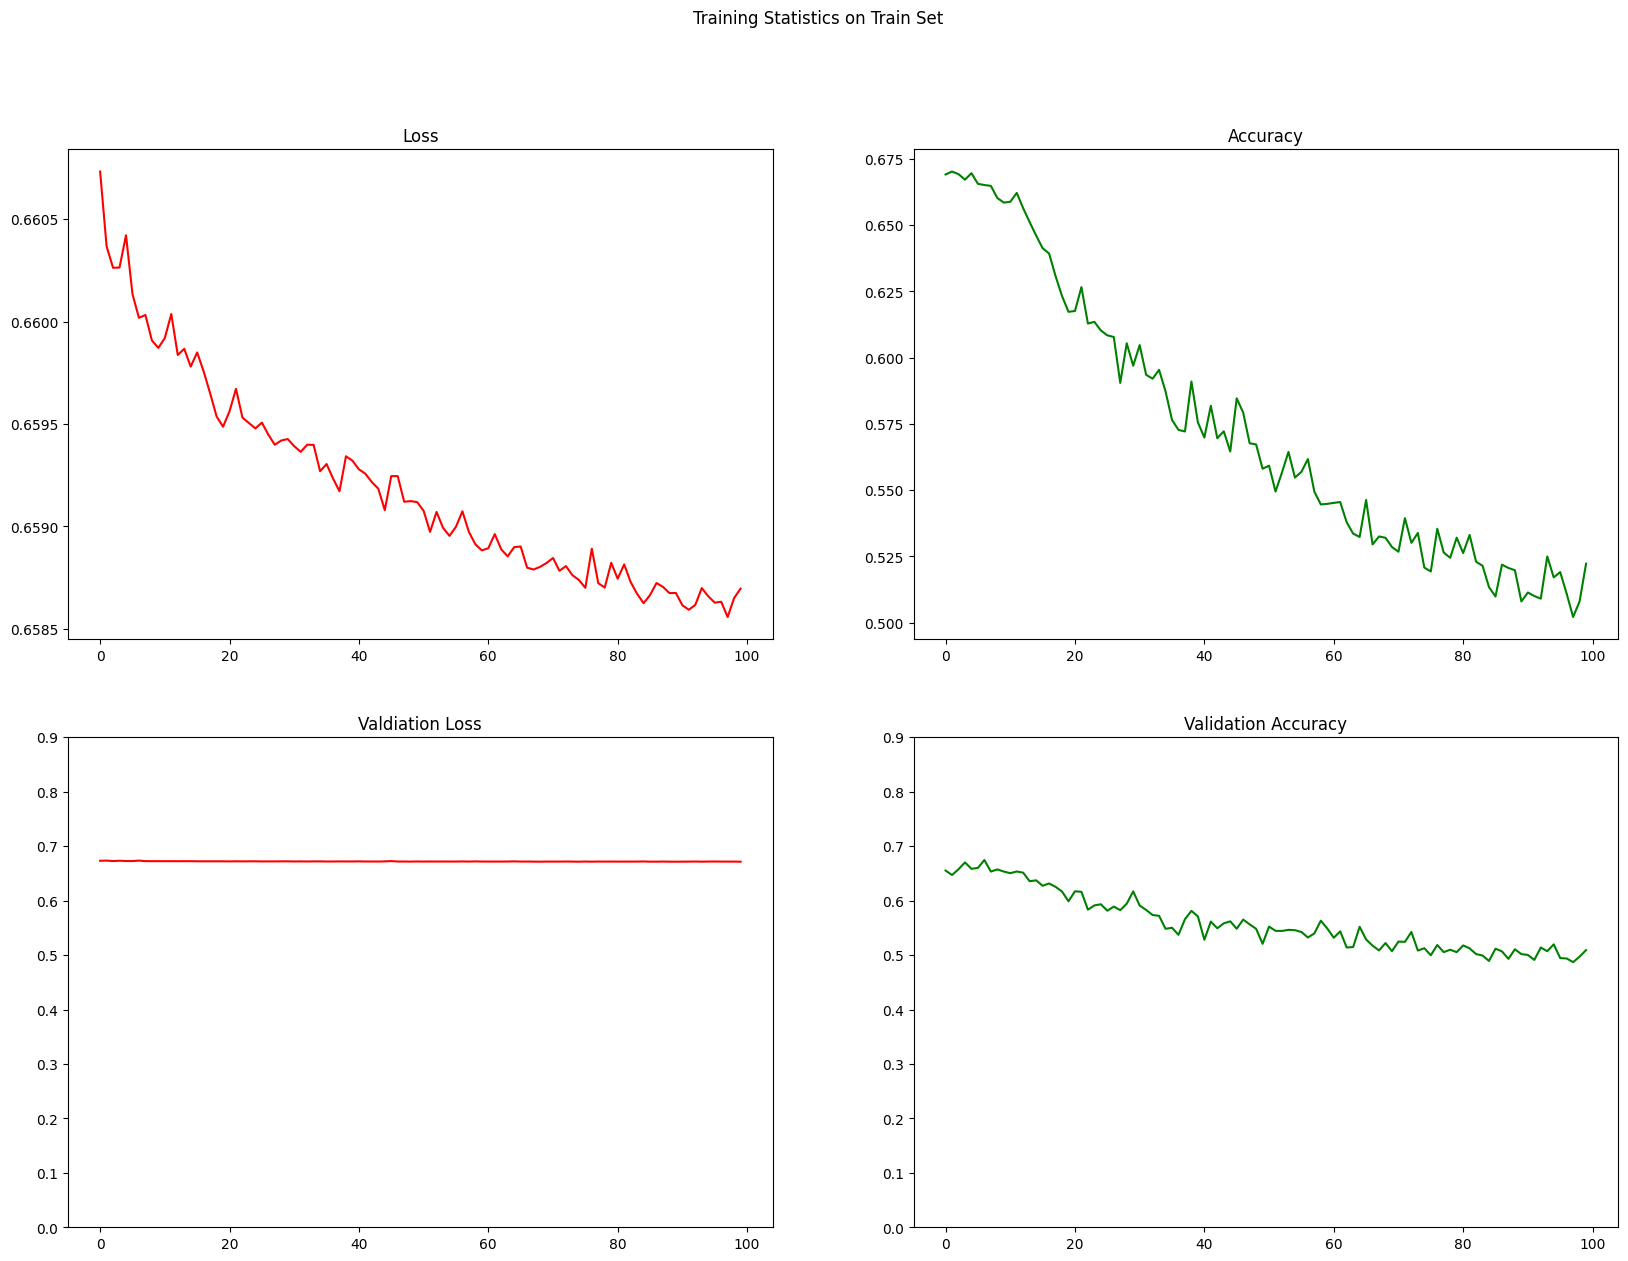

In [53]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(history.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(history.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

2024-04-25 18:56:16.241910: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.72318, expected 2.22985
2024-04-25 18:56:16.241973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.38867, expected 2.89534
2024-04-25 18:56:16.241983: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.47311, expected 2.97978
2024-04-25 18:56:16.241991: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64: 3.51732, expected 3.02399
2024-04-25 18:56:16.241998: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 67: 3.87081, expected 3.37748
2024-04-25 18:56:16.242006: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 3.19173, expected 2.69841
2024-04-25 18:56:16.242014: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 84: 3.54129, expected 3.04796
2024-04-25 18:56:16.242021: E external/local_xla

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


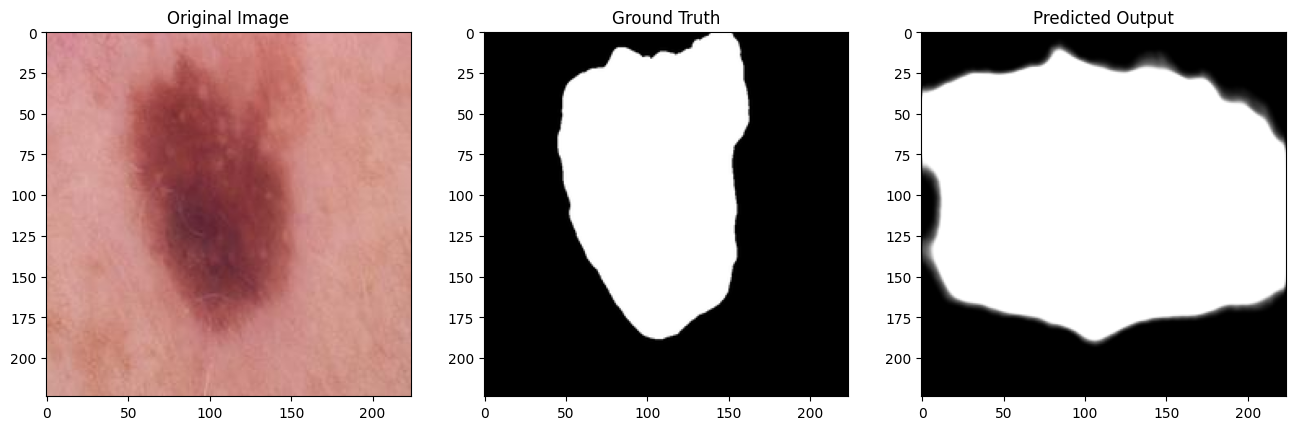

In [54]:
img_num = 49
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


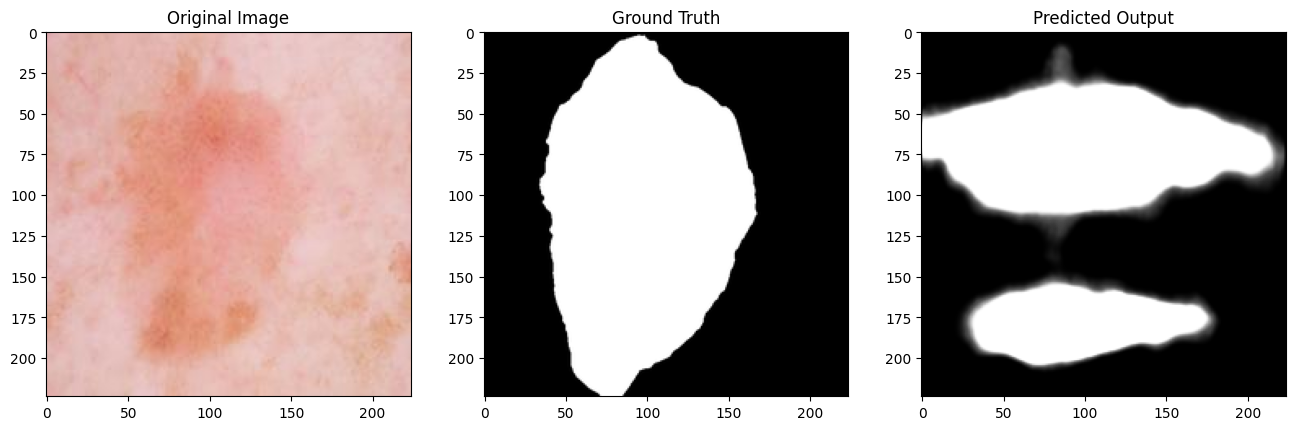

In [55]:
img_num = 1000
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


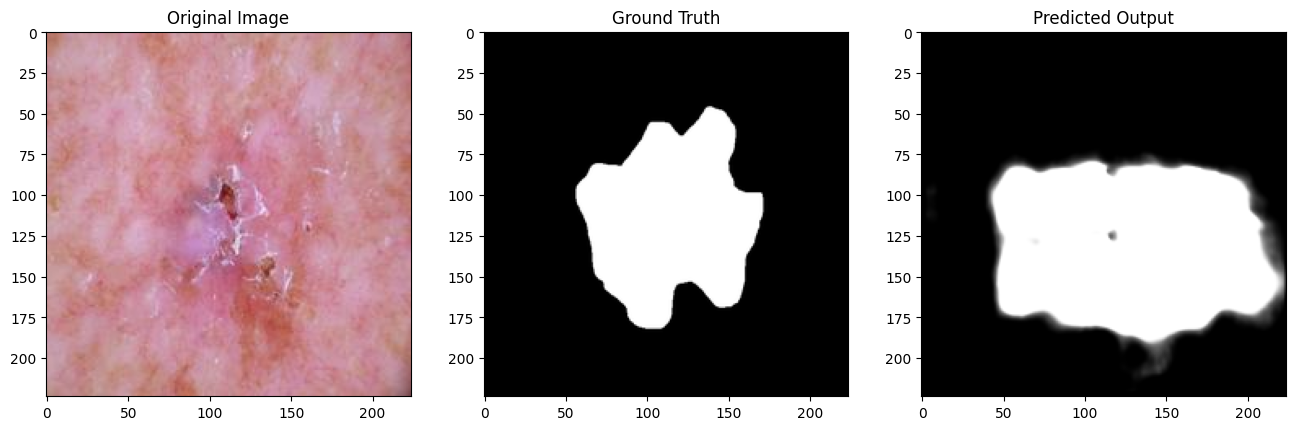

In [56]:
img_num = 540
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


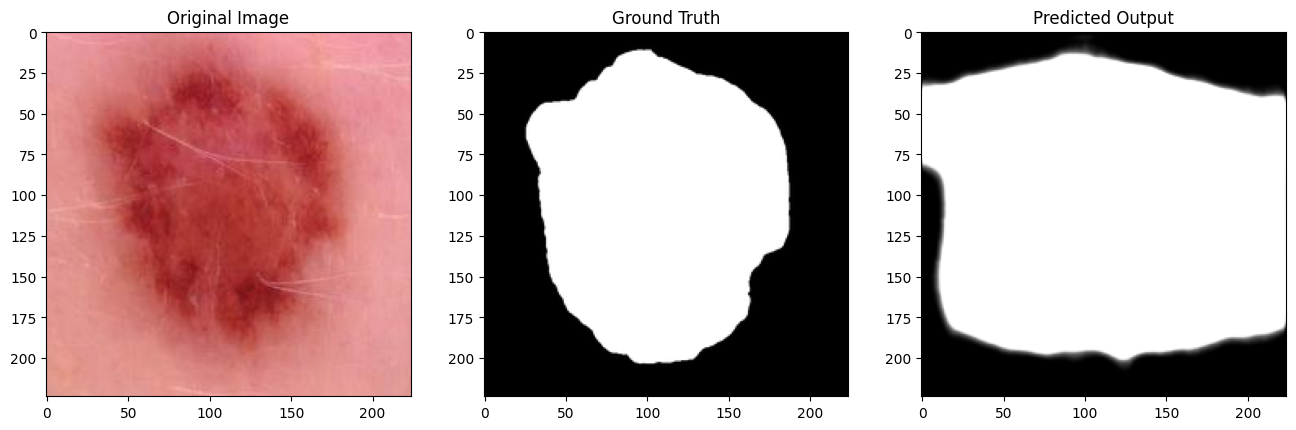

In [57]:
img_num = 325
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


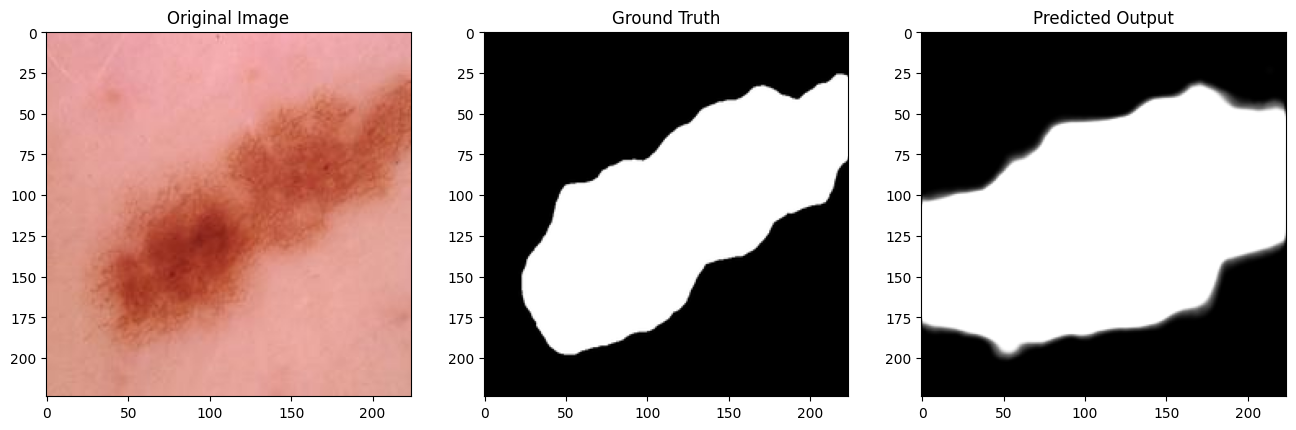

In [58]:
img_num = 1150
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


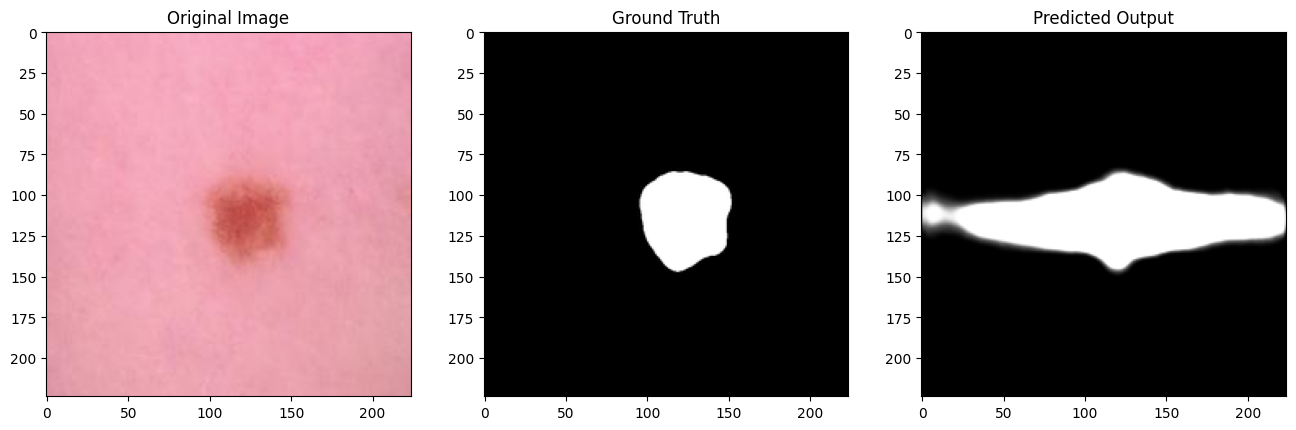

In [59]:
img_num = 218
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

In [61]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


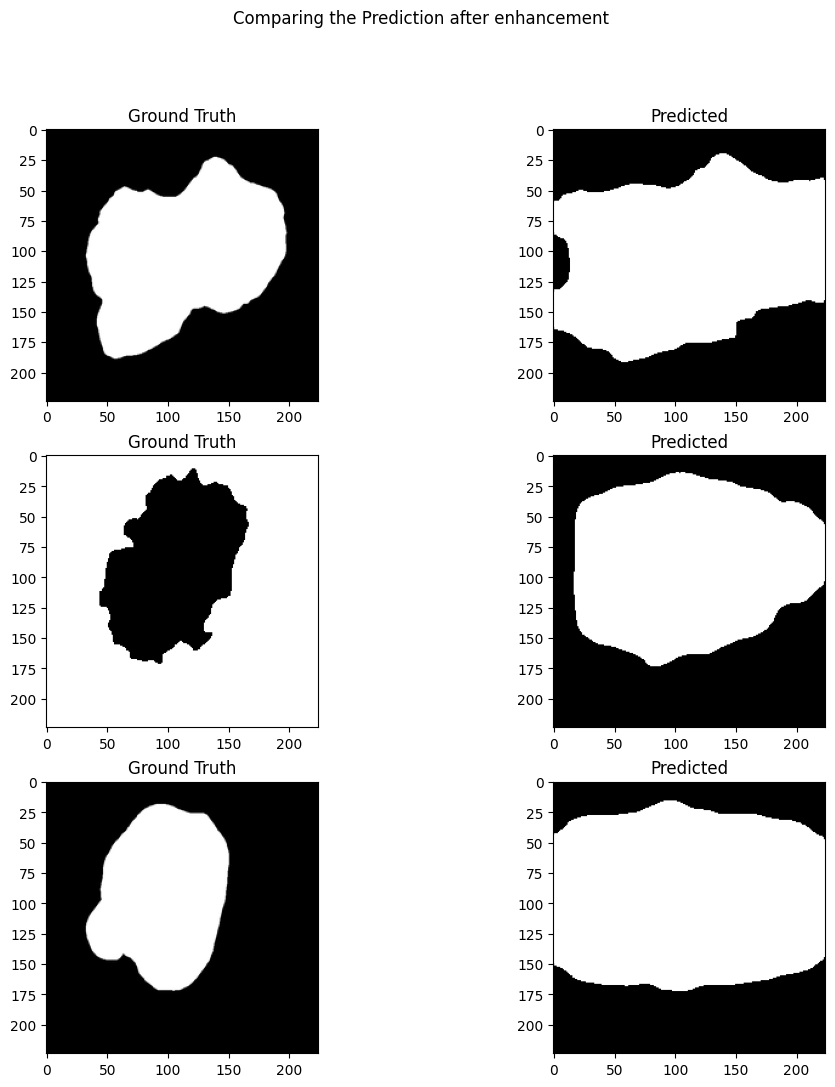

In [62]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()